In [8]:
import pandas as pd
import numpy as np
import nltk
import re
import string
import pickle
import requests
from bs4 import BeautifulSoup, SoupStrainer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt



In [9]:
def url_to_transcript(url):
    page = requests.get(url).text
    content = SoupStrainer("p")
    html_soup = BeautifulSoup(page, "html.parser", parse_only=content)
    text = [p.get_text() for p in html_soup.find_all('p')]
    print(url)
    return text

In [102]:
urls = ['https://www.vox.com/science-and-health/2019/1/18/18188199/drc-ebola-outbreak',
        'https://www.wired.com/story/the-drc-ebola-outbreak-is-an-end-of-year-nightmare']
transcripts = [url_to_transcript(u) for u in urls]

https://www.vox.com/science-and-health/2019/1/18/18188199/drc-ebola-outbreak
https://www.wired.com/story/the-drc-ebola-outbreak-is-an-end-of-year-nightmare


In [103]:
news_websites = ['vox', 'wired'] 

In [15]:
#for i, c in enumerate(news_websites):
     #with open(c + ".txt", "wb") as file:
         #pickle.dump(transcripts[i], file)

In [16]:
#data = {}
#for i, c in enumerate(news_websites):
    #with open(c + ".txt", "rb") as file:
        #data[c] = pickle.load(file)

In [108]:
data.keys()

dict_keys(['vox', 'wired'])

In [111]:
next(iter(data.keys()))

'vox'

In [ ]:
next(iter(data.values()))

In [6]:
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

In [ ]:
data_combined = {key: [combine_text(value)] for (key, value) in data.items()}

In [ ]:
pd.set_option('max_colwidth',150)

data_df = pd.DataFrame.from_dict(data_combined).transpose()
data_df.columns = ['transcript']
data_df = data_df.sort_index()
data_df

In [11]:
#data_df.transcript.loc['vox']

In [12]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [ ]:
# Let's take a look at the updated text
data_clean = pd.DataFrame(data_df.transcript.apply(round1))
data_clean

In [14]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text = TextBlob(text)
    text = text.tokenize()
    text = np.array(text)
    no_dup = []
    for word in np.nditer(text):
        w = Word(str(word))
        no_dup.append(w.lemmatize())
    text = combine_text(no_dup)
    return text

round2 = lambda x: clean_text_round2(x)

In [ ]:
# Let's take a look at the updated text
data_clean = pd.DataFrame(data_clean.transcript.apply(round2))
data_clean

In [16]:
#data_df.to_pickle("corpus.pkl")

In [17]:
data_clean = pd.DataFrame(pickle.load(open("data_clean.pkl", "rb")))


In [ ]:
# Let's take a look at the updated text
data_clean = pd.DataFrame(data_clean.transcript.apply(round2))
data_clean

In [19]:
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data_clean.transcript)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
data_dtm

,acceptance,according,aches,active,actually,ad,added,additional,advisory,affected,...,worry,worse,worst,written,wrote,year,years,youtube,zone,zones
vox,0,1,1,2,1,0,1,1,0,1,...,0,1,1,0,1,0,1,1,1,1
wired,1,1,0,0,0,1,0,1,1,1,...,1,0,0,1,0,2,0,0,0,2


In [20]:
#data_dtm.to_pickle("dtm.pkl")

In [21]:
#data_clean.to_pickle('data_clean.pkl')

In [22]:
#pickle.dump(cv, open("cv.pkl", "wb"))

In [23]:
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
import sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import scale
%matplotlib inline
np.set_printoptions(precision=4, suppress= True)
plt.figure(figsize=(45,20))
plt.style.use("seaborn-whitegrid")

<Figure size 3240x1440 with 0 Axes>

In [30]:
X = scale(data_dtm.T)

In [31]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_,counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

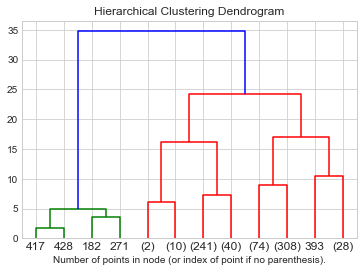

In [34]:
model = AgglomerativeClustering(linkage='ward',distance_threshold=0, n_clusters=None)
model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
#plt.savefig('D:\\Hierarchical Clustering Dendrogram.JPEG', dpi=500)
plt.show()

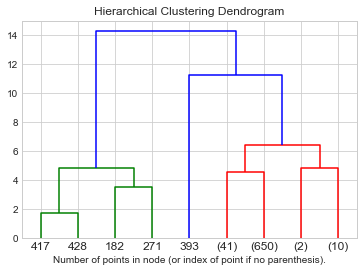

In [33]:
model = AgglomerativeClustering(linkage='complete',distance_threshold=0, n_clusters=None)
model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
#plt.savefig('D:\\Hierarchical Clustering Dendrogram.JPEG', dpi=500)
plt.show()

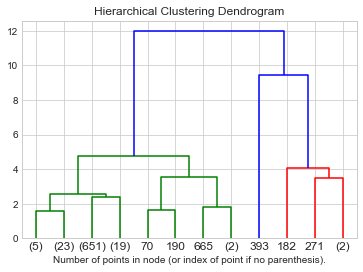

In [36]:
model = AgglomerativeClustering(linkage='average',distance_threshold=0, n_clusters=None)
model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
#plt.savefig('D:\\Hierarchical Clustering Dendrogram.JPEG', dpi=500)
plt.show()